In [28]:
import torch
from torch import nn, optim

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, classification_report


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import seaborn as sns
import pandas as pd
import numpy as np
import ast
from Bio import SeqIO

In [7]:
tox = pd.read_excel("../../out/data/blast_embed_tox.xlsx").drop(columns='Unnamed: 0')
tox

,Entry,Protein names,Organism,Protein families,Sequence,Signal peptide,Sequence_noSP,new_protein_family,shortened_label,manual_labels,mmseqs2_label,embed_label,combined
0,Q5Y4W9,U2-agatoxin-Ao1q (U2-AGTX-Ao1q) (Agel_16),Agelena orientalis (Funnel-web spider),Neurotoxin 01 (U2-agtx) family,MRSIISLLLISAMVFSMIAAVPEEEGLQLSEDERGGCLPHNRFCNA...,"SIGNAL 1..20; /evidence=""ECO:0000255""",VPEEEGLQLSEDERGGCLPHNRFCNALSGPRCFSGLRCKELSIWDS...,Agatoxin family,AGTX,0,28,30,"[0.011789458803832531, -0.026637909933924675, ..."
1,Q5Y4V1,U3-agatoxin-Ao1h (U3-AGTX-Ao1h) (Mu-2Aaga_09),Agelena orientalis (Funnel-web spider),"Neurotoxin 07 (Beta/delta-agtx) family, 03 (ag...",MRAIISLLLISTMVFGVIEAVSVQKSLKIFEGERGDCVGESQQCAD...,"SIGNAL 1..20; /evidence=""ECO:0000255""",VSVQKSLKIFEGERGDCVGESQQCADWSGPYCCKGYYCTCQYFPKC...,Agatoxin family,AGTX,0,28,30,"[0.07037654519081116, -0.006755341775715351, 0..."
2,Q5Y4V4,U3-agatoxin-Ao1e (U3-AGTX-Ao1e) (Mu-2Aga_06),Agelena orientalis (Funnel-web spider),"Neurotoxin 07 (Beta/delta-agtx) family, 03 (ag...",MRTIISLLLLSAMVFAVIEAISLEEGLQLFEGERGCVGENQQCADW...,"SIGNAL 1..20; /evidence=""ECO:0000255""",ISLEEGLQLFEGERGCVGENQQCADWAGPHCCSGYYCTCRYFPKCI...,Agatoxin family,AGTX,0,28,30,"[0.06326459348201752, -0.030541636049747467, 0..."
3,Q5Y4V0,U3-agatoxin-Ao1i (U3-AGTX-Ao1i) (Mu-2Aaga_10),Agelena orientalis (Funnel-web spider),"Neurotoxin 07 (Beta/delta-agtx) family, 03 (ag...",MRTIISLLLLSAMVFAEIEAISLEEGLQLFEGERGCVGENQQCANW...,"SIGNAL 1..20; /evidence=""ECO:0000255""",ISLEEGLQLFEGERGCVGENQQCANWAGPHCCSGYYCTCRYFPKCI...,Agatoxin family,AGTX,0,28,30,"[0.04777107760310173, -0.008298294618725777, 0..."
4,Q5Y4U9,U3-agatoxin-Ao1j (U3-AGTX-Ao1j) (Mu-2Aaga_11),Agelena orientalis (Funnel-web spider),"Neurotoxin 07 (Beta/delta-agtx) family, 03 (ag...",MRTIISLLLLSAMVFAVIEAISLEEGLQLFEGERGCVGENQQCADW...,"SIGNAL 1..20; /evidence=""ECO:0000255""",ISLEEGLQLFEGERGCVGENQQCADWARPHCCSGYYCTCRYFPKCI...,Agatoxin family,AGTX,0,28,30,"[0.044718291610479355, -0.013048099353909492, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5176,B1P1G3,U21-theraphotoxin-Cg1a 3 (U21-TRTX-Cg1a) (Jing...,Chilobrachys guangxiensis (Chinese earth tiger...,"Neurotoxin 10 (Hwtx-1) family, 05 (F4a) subfamily",MKVSVLITLAVLGVMFLLTSAEERGSDQMDSPAWLKSMERIFQSEE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",EERGSDQMDSPAWLKSMERIFQSEERECRWLFGGCEKDSDCCEHLG...,NaN,NaN,-1,34,30,"[-0.0034503983333706856, -0.021120255813002586..."
5177,B1P1G2,U21-theraphotoxin-Cg1a 1 (U21-TRTX-Cg1a) (Jing...,Chilobrachys guangxiensis (Chinese earth tiger...,"Neurotoxin 10 (Hwtx-1) family, 05 (F4a) subfamily",MKVSVLITLAVLGVMFLLTSAEERGSDQMDSPAWLKSMEIIFQSEE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",EERGSDQMDSPAWLKSMEIIFQSEERECRWLFGGCEKDSDCCEHLG...,NaN,NaN,-1,34,30,"[-0.0007040849886834621, -0.015479594469070435..."
5178,P56676,Mu/omega-theraphotoxin-Hs1a (Mu/omega-TRTX-Hs1...,Cyriopagopus schmidti (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 23 (HwTx-I) sub...",MRASMFLALAGLVLLFVVCYASESEEKEFPRELLFKFFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLFKFFAVDDFKGEERACKGVFDACTPGKNECCPN...,NaN,NaN,-1,36,24,"[0.04243668168783188, -0.0048881047405302525, ..."
5179,D2Y1Z2,Mu-theraphotoxin-Hhn2q (Mu-TRTX-Hhn2q) (Hainan...,Cyriopagopus hainanus (Chinese bird spider) (H...,"Neurotoxin 10 (Hwtx-1) family, 51 (Hntx-8) sub...",MKASMFLALAGLVLLFVVGYASESEEKEFPRELLSKIFAVDDFKGE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",SESEEKEFPRELLSKIFAVDDFKGEERGCKGFGDSCTPEKNECCPN...,NaN,NaN,-1,36,24,"[0.03860948979854584, -0.008861410431563854, 0..."


In [8]:
def read_fasta_to_df(file_path):
    records = SeqIO.parse(file_path, "fasta")
    return pd.DataFrame([(rec.id, str(rec.seq)) for rec in records], columns=["identifier", "Sequence"])

redundancy_reduced_seqs = read_fasta_to_df("../../dataset_generation/MMSeqs2/clustered_db_rep_seq.fasta")
redundancy_reduced_seqs

,identifier,Sequence
0,P0CV87,AKKRAGNGCFGLKLDRIGSMSGLGC
1,Q27J49,MFVSRLAASGLLLLALLAVSLDGKPVQQWSHKGWPPRPQIPPLVVQ...
2,Q90Y12,MFVSRLAASGLLLLALLAVSLDGKPLQQWSQRWPHLEIPPLVVQNW...
3,P0DMD6,KLSGCFGFKLDRIGTMSGLGC
4,B3EWY2,SYGISSGCFGLKLDRIGTMSGLGCWRLLQDSP
...,...,...
1283,C0HKG7,MKFSLFFSVFFLAVLHACLSESEIDLEDEEHFMSSDSFLSEIQDES...
1284,B1P1C7,MKTLVLFIIFGLAALFLLSSANELEETERGCGLLMDACDGKSTFCC...
1285,P0DPG5,GVDKEGCRYLLGACTIDDDCCLHLGCNKKYGHCGWDGTF
1286,B1P1G9,MKTSVLVTVLGLAVISVLCSASQDEEQDMYDELLSAVFEVNDELQS...


### data filtering

In [9]:
tox = pd.merge(tox, redundancy_reduced_seqs[['identifier']], left_on='Entry', right_on='identifier', how='inner')
tox

,Entry,Protein names,Organism,Protein families,Sequence,Signal peptide,Sequence_noSP,new_protein_family,shortened_label,manual_labels,mmseqs2_label,embed_label,combined,identifier
0,Q5Y4X0,U2-agatoxin-Ao1p (U2-AGTX-Ao1p) (Agel_15),Agelena orientalis (Funnel-web spider),Neurotoxin 01 (U2-agtx) family,MRAIISLILISAMVFSMIAAVPXXEGLQLSEDERGGCLPHNRFCNA...,"SIGNAL 1..20; /evidence=""ECO:0000255""",VPXXEGLQLSEDERGGCLPHNRFCNALSGPRCCSGLKCKELSIWDS...,Agatoxin family,AGTX,0,28,30,"[0.024765022099018097, -0.0025347971823066473,...",Q5Y4X0
1,Q5Y4V8,U3-agatoxin-Ao1a (U3-AGTX-Ao1a) (Beta/delta-ag...,Agelena orientalis (Funnel-web spider),"Neurotoxin 07 (Beta/delta-agtx) family, 01 (ag...",MKAVIFFCLLSVMVFTVIEAVKEEGTKPAEAARECAAKNKRCADWA...,"SIGNAL 1..20; /evidence=""ECO:0000255""",VKEEGTKPAEAARECAAKNKRCADWAGPWCCEGLYCSCRSYPGCMC...,Agatoxin family,AGTX,0,28,30,"[0.06169486045837402, -0.030714266002178192, 0...",Q5Y4V8
2,P31328,U2-agatoxin-Aop1a (U2-AGTX-Aop1a) (Agelenin),Allagelena opulenta (Funnel weaving spider) (A...,Neurotoxin 01 (U2-agtx) family,GGCLPHNRFCNALSGPRCCSGLKCKELSIWDSRCL,NaN,GGCLPHNRFCNALSGPRCCSGLKCKELSIWDSRCL,Agatoxin family,AGTX,0,28,30,"[0.049241796135902405, 0.05279087275266647, 0....",P31328
3,A0A0D4WV12,Dermonecrotic toxin StSicTox-betaIB1i (EC 4.6....,Sicarius terrosus (Cave spider),"Arthropod phospholipase D family, Class II sub...",GDSRRPIWNIAHMVNDLDLVDEYLDDGANSLELDVEFSKSGTALRT...,NaN,GDSRRPIWNIAHMVNDLDLVDEYLDDGANSLELDVEFSKSGTALRT...,Arthropod phospholipase D family,APLAD,1,7,4,"[0.07936816662549973, -0.035466499626636505, 0...",A0A0D4WV12
4,P0DM60,Dermonecrotic toxin LiSicTox-alphaIVA1 (EC 4.6...,Loxosceles intermedia (Brown spider),"Arthropod phospholipase D family, Class II sub...",MLFPTALIFGCWALVIEGADNRRPIWNMGHMVNEVYQIDEFVDLGA...,"SIGNAL 1..18; /evidence=""ECO:0000255""",ADNRRPIWNMGHMVNEVYQIDEFVDLGANSIETDITFDDDAMAEYS...,Arthropod phospholipase D family,APLAD,1,7,4,"[0.09940161556005478, -0.03533587232232094, 0....",P0DM60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,B1P1G1,U21-theraphotoxin-Cg1a 4 (U21-TRTX-Cg1a) (Jing...,Chilobrachys guangxiensis (Chinese earth tiger...,"Neurotoxin 10 (Hwtx-1) family, 05 (F4a) subfamily",MKVSVLITLAVLGVMFLLTSAEERGSDQMDSPAWLKSMEIIFQSEE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",EERGSDQMDSPAWLKSMEIIFQSEERECRWLFGGCEKDSDCCEHLG...,NaN,NaN,-1,34,-1,"[0.04534151032567024, 0.013253556564450264, 0....",B1P1G1
1284,B1P1H9,U28-theraphotoxin-Cg1a (U28-TRTX-Cg1a) (Jingzh...,Chilobrachys guangxiensis (Chinese earth tiger...,"Neurotoxin 10 (Hwtx-1) family, 45 (Jztx-60) su...",MKVAIAICRNIWYSEALSEMNTQILVSILGLAILAALSSGAKAAEP...,"SIGNAL 1..43; /evidence=""ECO:0000255""",AEPELAVEVSELLKAMEHAPQPQERECRWFWGACKSDSDCCRYLGC...,NaN,NaN,-1,34,30,"[0.0007677673711441457, -0.03326551616191864, ...",B1P1H9
1285,B1P1F8,U20-theraphotoxin-Cg1a 2 (U20-TRTX-Cg1a) (Jing...,Chilobrachys guangxiensis (Chinese earth tiger...,"Neurotoxin 10 (Hwtx-1) family, 40 (Jztx-35) su...",MQVSVLITLAVLGVMFVWTSAAELEERGSDQPAWLKSLERIFQSEE...,"SIGNAL 1..21; /evidence=""ECO:0000255""",AELEERGSDQPAWLKSLERIFQSEERDCRALYGGCTKDEDCCKHLA...,NaN,NaN,-1,34,30,"[0.008412325754761696, 0.003949272446334362, 0...",B1P1F8
1286,P60590,Omega-theraphotoxin-Gr1a (Omega-TRTX-Gr1a) (Om...,Grammostola rosea (Chilean rose tarantula) (Gr...,"Neurotoxin 10 (Hwtx-1) family, 07 (GrTx) subfa...",MKAQIFVVVLGLAALSVLCYGSEADESALHEEIFQLLAASDEVPKP...,"SIGNAL 1..24; /evidence=""ECO:0000255""",DESALHEEIFQLLAASDEVPKPQERDCVRFWGKCSQTSDCCPHLAC...,NaN,NaN,-1,34,30,"[-0.0003394061350263655, -0.02454487793147564,...",P60590


In [10]:
tox['new_protein_family'].value_counts()

new_protein_family
Long scorpion toxin superfamily                       52
Snake three-finger toxin family                       38
Short scorpion toxin superfamily                      23
Conotoxin O1 superfamily                              21
Bradykinin-potentiating peptide family                19
Natriuretic peptide family                            18
Venom Kunitz-type family                              18
Neurotoxin 14 (magi-1) family                         12
Snaclec family                                        11
Conotoxin O2 superfamily                               9
Scoloptoxin-16 family                                  8
Phospholipase A2 family                                8
Venom metalloproteinase (M12B) family                  8
Conotoxin M superfamily                                6
Conotoxin A superfamily                                6
Latarcin, Cytoinsectotoxin family                      6
Conotoxin T superfamily                                5
Cationic pep

In [11]:
tox_filtered = tox[tox['manual_labels'] != -1]
label_counts = tox_filtered['manual_labels'].value_counts()
valid_labels = label_counts[label_counts > 5].index
tox_filtered = tox_filtered[tox_filtered['manual_labels'].isin(valid_labels)]

tox_filtered['embeddings'] = tox_filtered['combined'].apply(ast.literal_eval)

tox_filtered['new_protein_family'].value_counts()

new_protein_family
Long scorpion toxin superfamily           52
Snake three-finger toxin family           38
Short scorpion toxin superfamily          23
Conotoxin O1 superfamily                  21
Bradykinin-potentiating peptide family    19
Natriuretic peptide family                18
Venom Kunitz-type family                  18
Neurotoxin 14 (magi-1) family             12
Snaclec family                            11
Conotoxin O2 superfamily                   9
Phospholipase A2 family                    8
Scoloptoxin-16 family                      8
Venom metalloproteinase (M12B) family      8
Conotoxin A superfamily                    6
Conotoxin M superfamily                    6
Latarcin, Cytoinsectotoxin family          6
Name: count, dtype: int64

In [12]:
tox_filtered

,Entry,Protein names,Organism,Protein families,Sequence,Signal peptide,Sequence_noSP,new_protein_family,shortened_label,manual_labels,mmseqs2_label,embed_label,combined,identifier,embeddings
6,P0C7S4,Bradykinin-potentiating peptide 9a (BPP-9) (BP...,Bothrops neuwiedi (Neuwied's lancehead),Bradykinin-potentiating peptide family,QWPRPQIPP,NaN,QWPRPQIPP,Bradykinin-potentiating peptide family,BPP,2,-1,0,"[0.19914527237415314, -0.011205417104065418, 0...",P0C7S4,"[0.19914527237415314, -0.011205417104065418, 0..."
7,P0C7K2,Bradykinin-potentiating peptide 11b (BPP-11b),Crotalus viridis viridis (Prairie rattlesnake),Bradykinin-potentiating peptide family,QGGAPWNPIPP,NaN,QGGAPWNPIPP,Bradykinin-potentiating peptide family,BPP,2,-1,0,"[0.11428461223840714, 0.027730949223041534, 0....",P0C7K2,"[0.11428461223840714, 0.027730949223041534, 0...."
8,P0DJK6,Bradykinin-potentiating peptide 11h (BPP-11h),Bothrops jararaca (Jararaca) (Bothrops jajaraca),Bradykinin-potentiating peptide family,QGRHPPIPPAP,NaN,QGRHPPIPPAP,Bradykinin-potentiating peptide family,BPP,2,-1,0,"[0.20194576680660248, -0.031102826818823814, -...",P0DJK6,"[0.20194576680660248, -0.031102826818823814, -..."
9,P0C7S5,Bradykinin-potentiating peptide 11 (BPP-11),Bothrops neuwiedi (Neuwied's lancehead),Bradykinin-potentiating peptide family,QWPRPTPQIPP,NaN,QWPRPTPQIPP,Bradykinin-potentiating peptide family,BPP,2,-1,0,"[0.2068648785352707, -0.01082045678049326, 0.0...",P0C7S5,"[0.2068648785352707, -0.01082045678049326, 0.0..."
10,P01022,Bradykinin-potentiating peptide 10b (BPP-10b) ...,Bothrops jararaca (Jararaca) (Bothrops jajaraca),Bradykinin-potentiating peptide family,QNWPRPQIPP,NaN,QNWPRPQIPP,Bradykinin-potentiating peptide family,BPP,2,-1,0,"[0.16062608361244202, 0.0014429298462346196, 0...",P01022,"[0.16062608361244202, 0.0014429298462346196, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,U6BLN5,Venom metalloproteinase BumaMPs1 (MPs1) (EC 3....,Mesobuthus martensii (Manchurian scorpion) (Bu...,Venom metalloproteinase (M12B) family,MFVHLLVLLFAAVEAIPTGRFEVVYPSMVTFRSGIKRIRFRALDED...,"SIGNAL 1..15; /evidence=""ECO:0000255""",IPTGRFEVVYPSMVTFRSGIKRIRFRALDEDIELRLEPAGDVIADD...,Venom metalloproteinase (M12B) family,VMP,35,11,9,"[0.027564674615859985, -0.023134838789701462, ...",U6BLN5,"[0.027564674615859985, -0.023134838789701462, ..."
311,A0A1E1WVX2,Metalloproteinase (EC 3.4.24.-),Tityus obscurus (Amazonian scorpion) (Tityus c...,Venom metalloproteinase (M12B) family,MYLAYIFFLFATVSAIPTGRVEIVFPSVETSRSGMKTVKFRALGED...,"SIGNAL 1..15; /evidence=""ECO:0000255""",IPTGRVEIVFPSVETSRSGMKTVKFRALGEDVELKLEPAGDILAQD...,Venom metalloproteinase (M12B) family,VMP,35,11,9,"[0.014069925993680954, -0.03229266777634621, 0...",A0A1E1WVX2,"[0.014069925993680954, -0.03229266777634621, 0..."
312,Q9W6M5,Zinc metalloproteinase-disintegrin-like acurha...,Deinagkistrodon acutus (Hundred-pace snake) (A...,"Venom metalloproteinase (M12B) family, P-III s...",MIQVLLVTICLAAFPYQGSSIILESGDVNDYEVVYPRKVTALPKGA...,"SIGNAL 1..20; /evidence=""ECO:0000255""",IILESGDVNDYEVVYPRKVTALPKGAVQQKYEDAMQYEFKVNGEPV...,Venom metalloproteinase (M12B) family,VMP,35,11,9,"[0.02913854829967022, 0.07319614291191101, 0.0...",Q9W6M5,"[0.02913854829967022, 0.07319614291191101, 0.0..."
313,Q9PW35,Snake venom metalloproteinase acutolysin-A (SV...,Deinagkistrodon acutus (Hundred-pace snake) (A...,"Venom metalloproteinase (M12B) family, P-I sub...",MIQVLLVTICLAAFPYQGSSIILESGNVNDYEVVYPRKVTALPKGA...,"SIGNAL 1..20; /evidence=""ECO:0000255""",IILESGNVNDYEVVYPRKVTALPKGAVQQKYEDAMQYEFKVNGEPV...,Venom metalloproteinase (M12B) family,VMP,35,11,9,"[0.030197016894817352, 0.0276663638651371, 0.0...",Q9PW35,"[0.030197016894817352, 0.0276663638651371, 0.0..."


### label preprocessing

In [13]:
X = torch.tensor(tox_filtered['embeddings'].to_list(), dtype=torch.float32)

# Encode labels (new_protein_family) as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(tox_filtered['new_protein_family'])
y = torch.tensor(y, dtype=torch.long)

# model
## architecture and oversampling

In [34]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
input_dim = X.shape[1] 
hidden_dim = 128
output_dim = len(np.unique(y)) 


1024


## training and stratified 5-fold-cross-validation

Train size: 183
weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
class counts: [13  4  4 15  7  4 36 12  8  6  6 17  7 26 12  6]
Epoch [10/100] | Train Loss: 0.5410 | Validation Loss: 0.6587
Epoch [20/100] | Train Loss: 0.0884 | Validation Loss: 0.3599
Early stopping at epoch 28

Validation Accuracy: 0.9250
Validation MCC: 0.9198

Class: Bradykinin-potentiating peptide family
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Class: Conotoxin A superfamily
  Precision: 0.3333
  Recall: 1.0000
  F1-score: 0.5000

Class: Conotoxin M superfamily
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Class: Conotoxin O1 superfamily
  Precision: 1.0000
  Recall: 0.6667
  F1-score: 0.8000

Class: Conotoxin O2 superfamily
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Class: Latarcin, Cytoinsectotoxin family
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000

Class: Long scorpion toxin superfamily
  Precision: 0.8889
  Recall: 1.0000
  F1-score: 0.9412

Class:

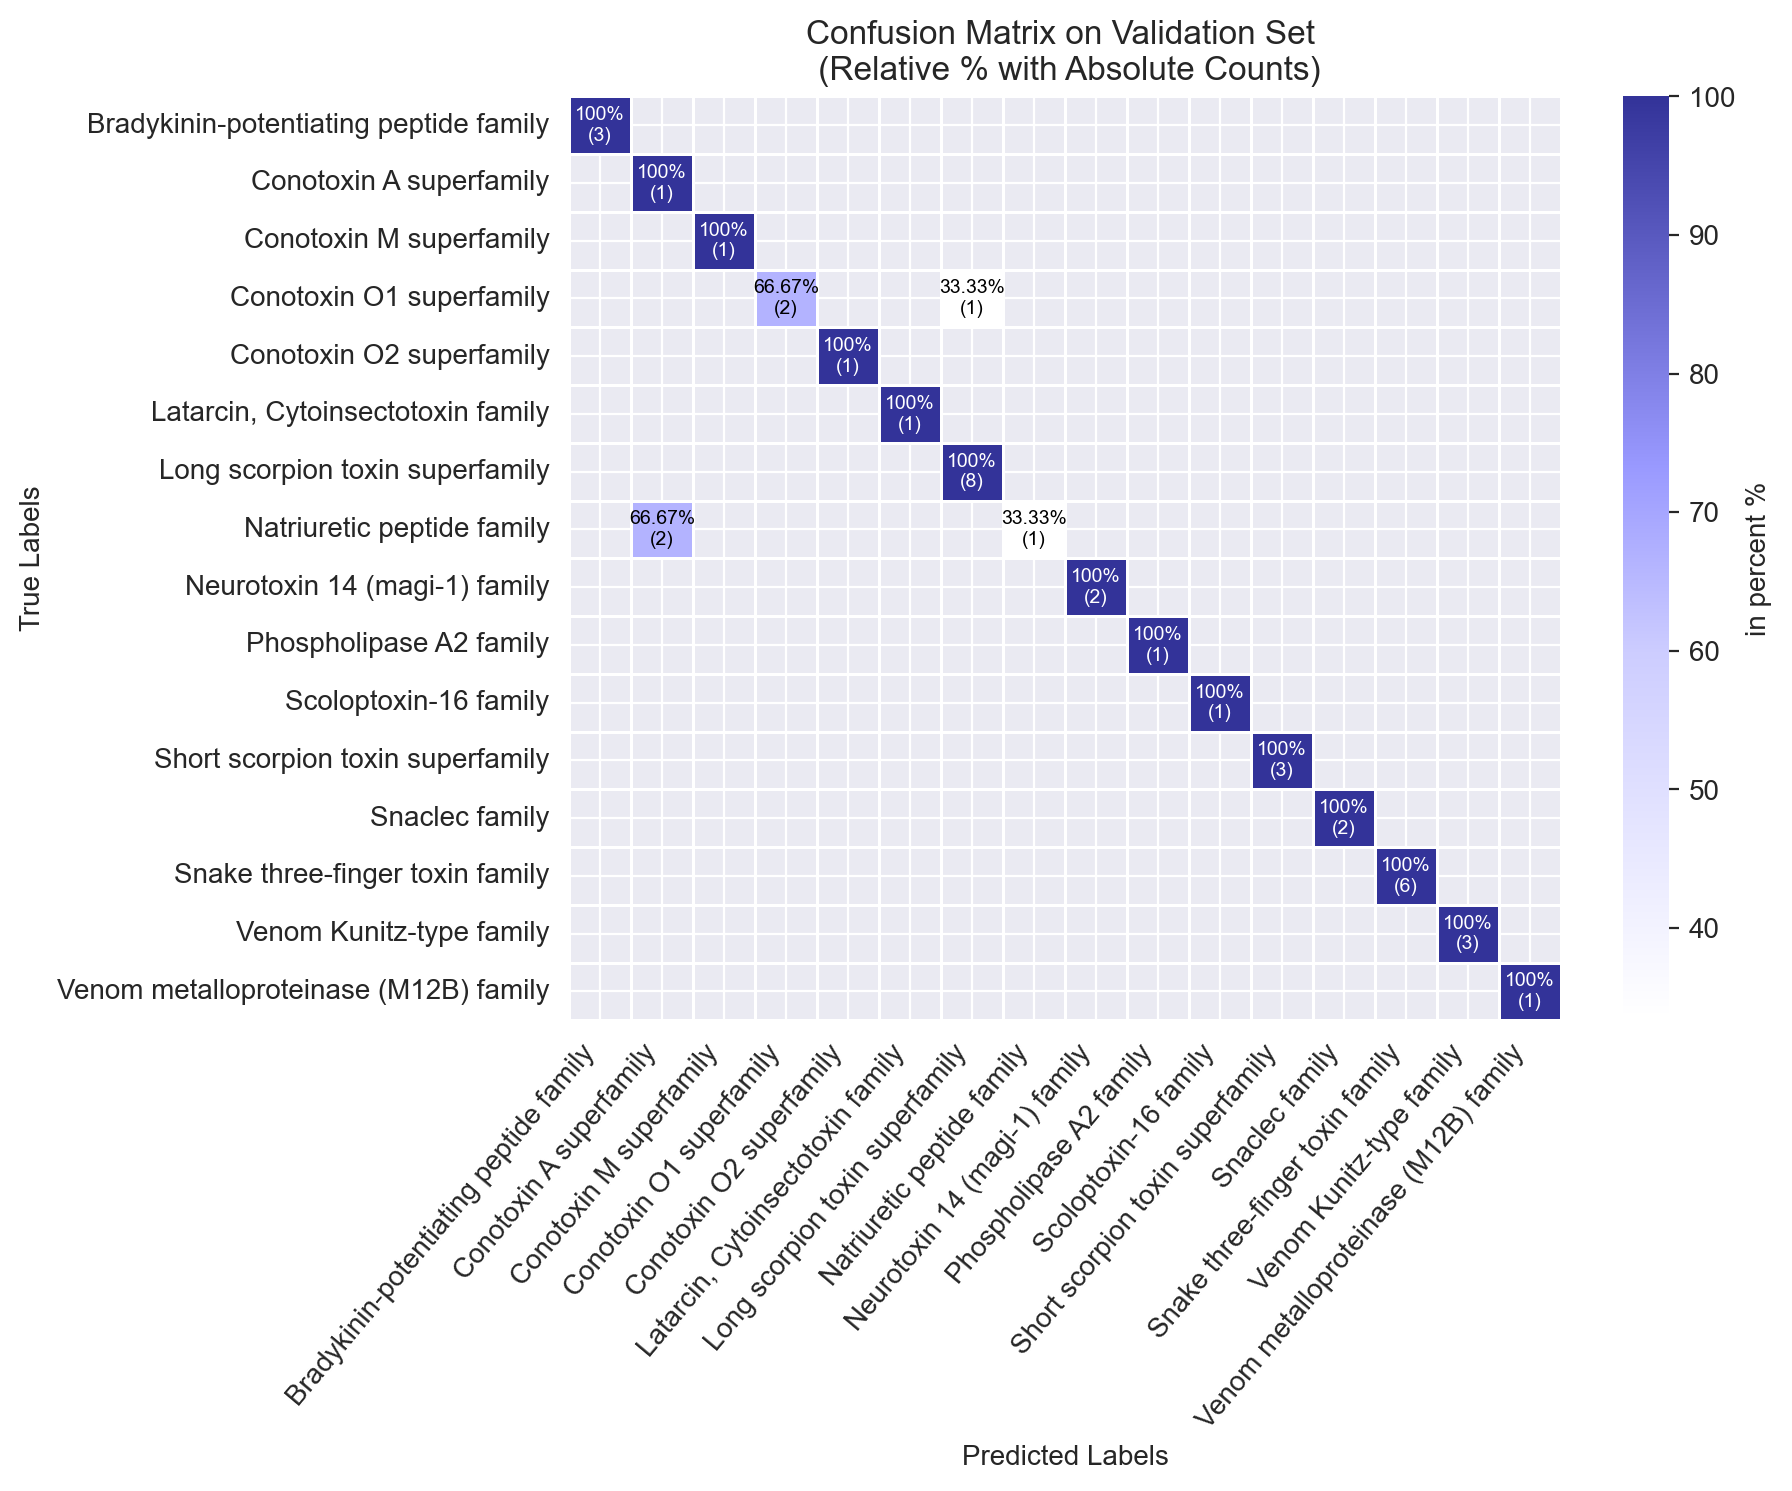


Training Losses:
Epoch 1: 2.7579
Epoch 2: 2.4732
Epoch 3: 2.0950
Epoch 4: 1.7799
Epoch 5: 1.5377
Epoch 6: 1.2979
Epoch 7: 1.0586
Epoch 8: 0.8516
Epoch 9: 0.6815
Epoch 10: 0.5410
Epoch 11: 0.4323
Epoch 12: 0.3590
Epoch 13: 0.3036
Epoch 14: 0.2478
Epoch 15: 0.2020
Epoch 16: 0.1677
Epoch 17: 0.1396
Epoch 18: 0.1183
Epoch 19: 0.1021
Epoch 20: 0.0884
Epoch 21: 0.0757
Epoch 22: 0.0635
Epoch 23: 0.0545
Epoch 24: 0.0467
Epoch 25: 0.0404
Epoch 26: 0.0349
Epoch 27: 0.0300
Epoch 28: 0.0262

Validation Losses:
Epoch 1: 2.4931
Epoch 2: 2.1380
Epoch 3: 1.8560
Epoch 4: 1.6538
Epoch 5: 1.4470
Epoch 6: 1.2246
Epoch 7: 1.0228
Epoch 8: 0.8606
Epoch 9: 0.7391
Epoch 10: 0.6587
Epoch 11: 0.6177
Epoch 12: 0.5877
Epoch 13: 0.5462
Epoch 14: 0.5047
Epoch 15: 0.4681
Epoch 16: 0.4350
Epoch 17: 0.4109
Epoch 18: 0.3943
Epoch 19: 0.3789
Epoch 20: 0.3599
Epoch 21: 0.3391
Epoch 22: 0.3250
Epoch 23: 0.3197
Epoch 24: 0.3219
Epoch 25: 0.3248
Epoch 26: 0.3254
Epoch 27: 0.3269
Epoch 28: 0.3309


In [32]:
with open("model_training_output.txt", "w") as f:
    with open("metrics_output.txt", "w") as metrics_file:

        def print_to_file(*args, **kwargs):
            print(*args, **kwargs)
            print(*args, **kwargs, file=f)

            # Save relevant metrics to metrics_file
            if any(term in str(args) for term in ["Accuracy", "MCC", "Precision", "Class:", "F1-score", "Recall"]):
                print(*args, **kwargs, file=metrics_file)

        # Split the data
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.15 / 0.85, random_state=42, stratify=y_train_val)

        print_to_file(f"Train size: {len(X_train)}")

        # Calculate class weights
        class_counts = np.bincount(y_train.numpy())  
        majority_class_index = np.argmax(class_counts)
        weights = np.ones_like(class_counts, dtype=np.float32)        

        print_to_file(f"weights: {weights}\nclass counts: {class_counts}")

        # Model initialization
        model = MLPClassifier(input_dim, hidden_dim, output_dim)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        train_losses = []
        valid_losses = []

        # Early stopping parameters
        patience = 5
        best_valid_loss = float('inf')
        patience_counter = 0

        # Train the model
        num_epochs = 100
        for epoch in range(num_epochs):
            model.train()
            outputs = model(X_train)
            train_loss = criterion(outputs, y_train)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            train_losses.append(train_loss.item())

            model.eval()
            with torch.no_grad():
                outputs = model(X_valid)
                valid_loss = criterion(outputs, y_valid)

                valid_losses.append(valid_loss.item())

            if valid_loss.item() < best_valid_loss:
                best_valid_loss = valid_loss.item()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print_to_file(f"Early stopping at epoch {epoch + 1}")
                break

            if (epoch + 1) % 10 == 0:
                print_to_file(f"Epoch [{epoch+1}/{num_epochs}] | "
                              f"Train Loss: {train_loss.item():.4f} | "
                              f"Validation Loss: {valid_loss.item():.4f}")

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            outputs = model(X_valid)
            _, predicted = torch.max(outputs, 1)

            accuracy = accuracy_score(y_valid.numpy(), predicted.numpy())
            mcc = matthews_corrcoef(y_valid.numpy(), predicted.numpy())

            # Classification report
            class_report = classification_report(y_valid.numpy(), predicted.numpy(), target_names=label_encoder.classes_, output_dict=True, zero_division=np.nan)

            print_to_file(f"\nValidation Accuracy: {accuracy:.4f}")
            print_to_file(f"Validation MCC: {mcc:.4f}")

            for class_name, metrics in class_report.items():
                if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                    print_to_file(f"\nClass: {class_name}")
                    print_to_file(f"  Precision: {metrics['precision']:.4f}")
                    print_to_file(f"  Recall: {metrics['recall']:.4f}")
                    print_to_file(f"  F1-score: {metrics['f1-score']:.4f}")

            # Confusion matrix
            predicted_labels = label_encoder.inverse_transform(predicted.numpy())
            true_labels = label_encoder.inverse_transform(y_valid.numpy())
            cm = confusion_matrix(true_labels, predicted_labels)
            cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            cm_percentage = np.clip(cm_percentage, 0, 100)

            colors = [
                (1, 1, 1),        
                (0.9, 0.9, 1),    
                (0.8, 0.8, 1),     
                (0.6, 0.6, 1),     
                (0.4, 0.4, 0.8),   
                (0.2, 0.2, 0.6),  
            ]

            cmap = LinearSegmentedColormap.from_list("custom_lilac", colors)

            boundaries = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 100, 101]
            norm = BoundaryNorm(boundaries, cmap.N)
            
            fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

            cm_percentage_no_zeros = np.where(cm == 0, np.nan, cm_percentage)
            
            sns.heatmap(
                cm_percentage_no_zeros,
                annot=False,
                cmap=cmap,
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'in percent %'},
                fmt=".0f",
                linewidths=1,  
                ax=ax,
            )
            plt.xticks(rotation=50, ha='right')

            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    if cm[i, j] > 0:
                        percentage_value = cm_percentage[i, j]
                        if percentage_value % 1 == 0:
                            relative_text = f"{percentage_value:.0f}%"
                        elif (round(percentage_value,2) * 10) % 1 == 0:
                            relative_text = f"{percentage_value:.1f}%"
                        else:
                            relative_text = f"{percentage_value:.2f}%"

            
                        absolute_text = f"{cm[i, j]:d}"
            
                        background_color = cmap(norm(percentage_value))
                        brightness = (background_color[0] * 0.299 +
                                      background_color[1] * 0.587 +
                                      background_color[2] * 0.114)
                        font_color = 'white' if brightness < 0.5 else 'black'
            
                        ax.text(
                            j + 0.5, i + 0.5, 
                            f"{relative_text}\n({absolute_text})", 
                            ha='center', va='center', 
                            fontsize=7, color=font_color
                        )

            
            # Titles and labels
            plt.title("Confusion Matrix on Validation Set \n (Relative % with Absolute Counts)")
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            
            plt.savefig("cm_val.png", bbox_inches='tight')
            plt.show()

        print_to_file(f"\nTraining Losses:")
        for epoch, loss in enumerate(train_losses, 1):
            print_to_file(f"Epoch {epoch}: {loss:.4f}")

        print_to_file(f"\nValidation Losses:")
        for epoch, loss in enumerate(valid_losses, 1):
            print_to_file(f"Epoch {epoch}: {loss:.4f}")


### testing

Test Accuracy: 0.9750
Test Matthews Correlation Coefficient (MCC): 0.9729


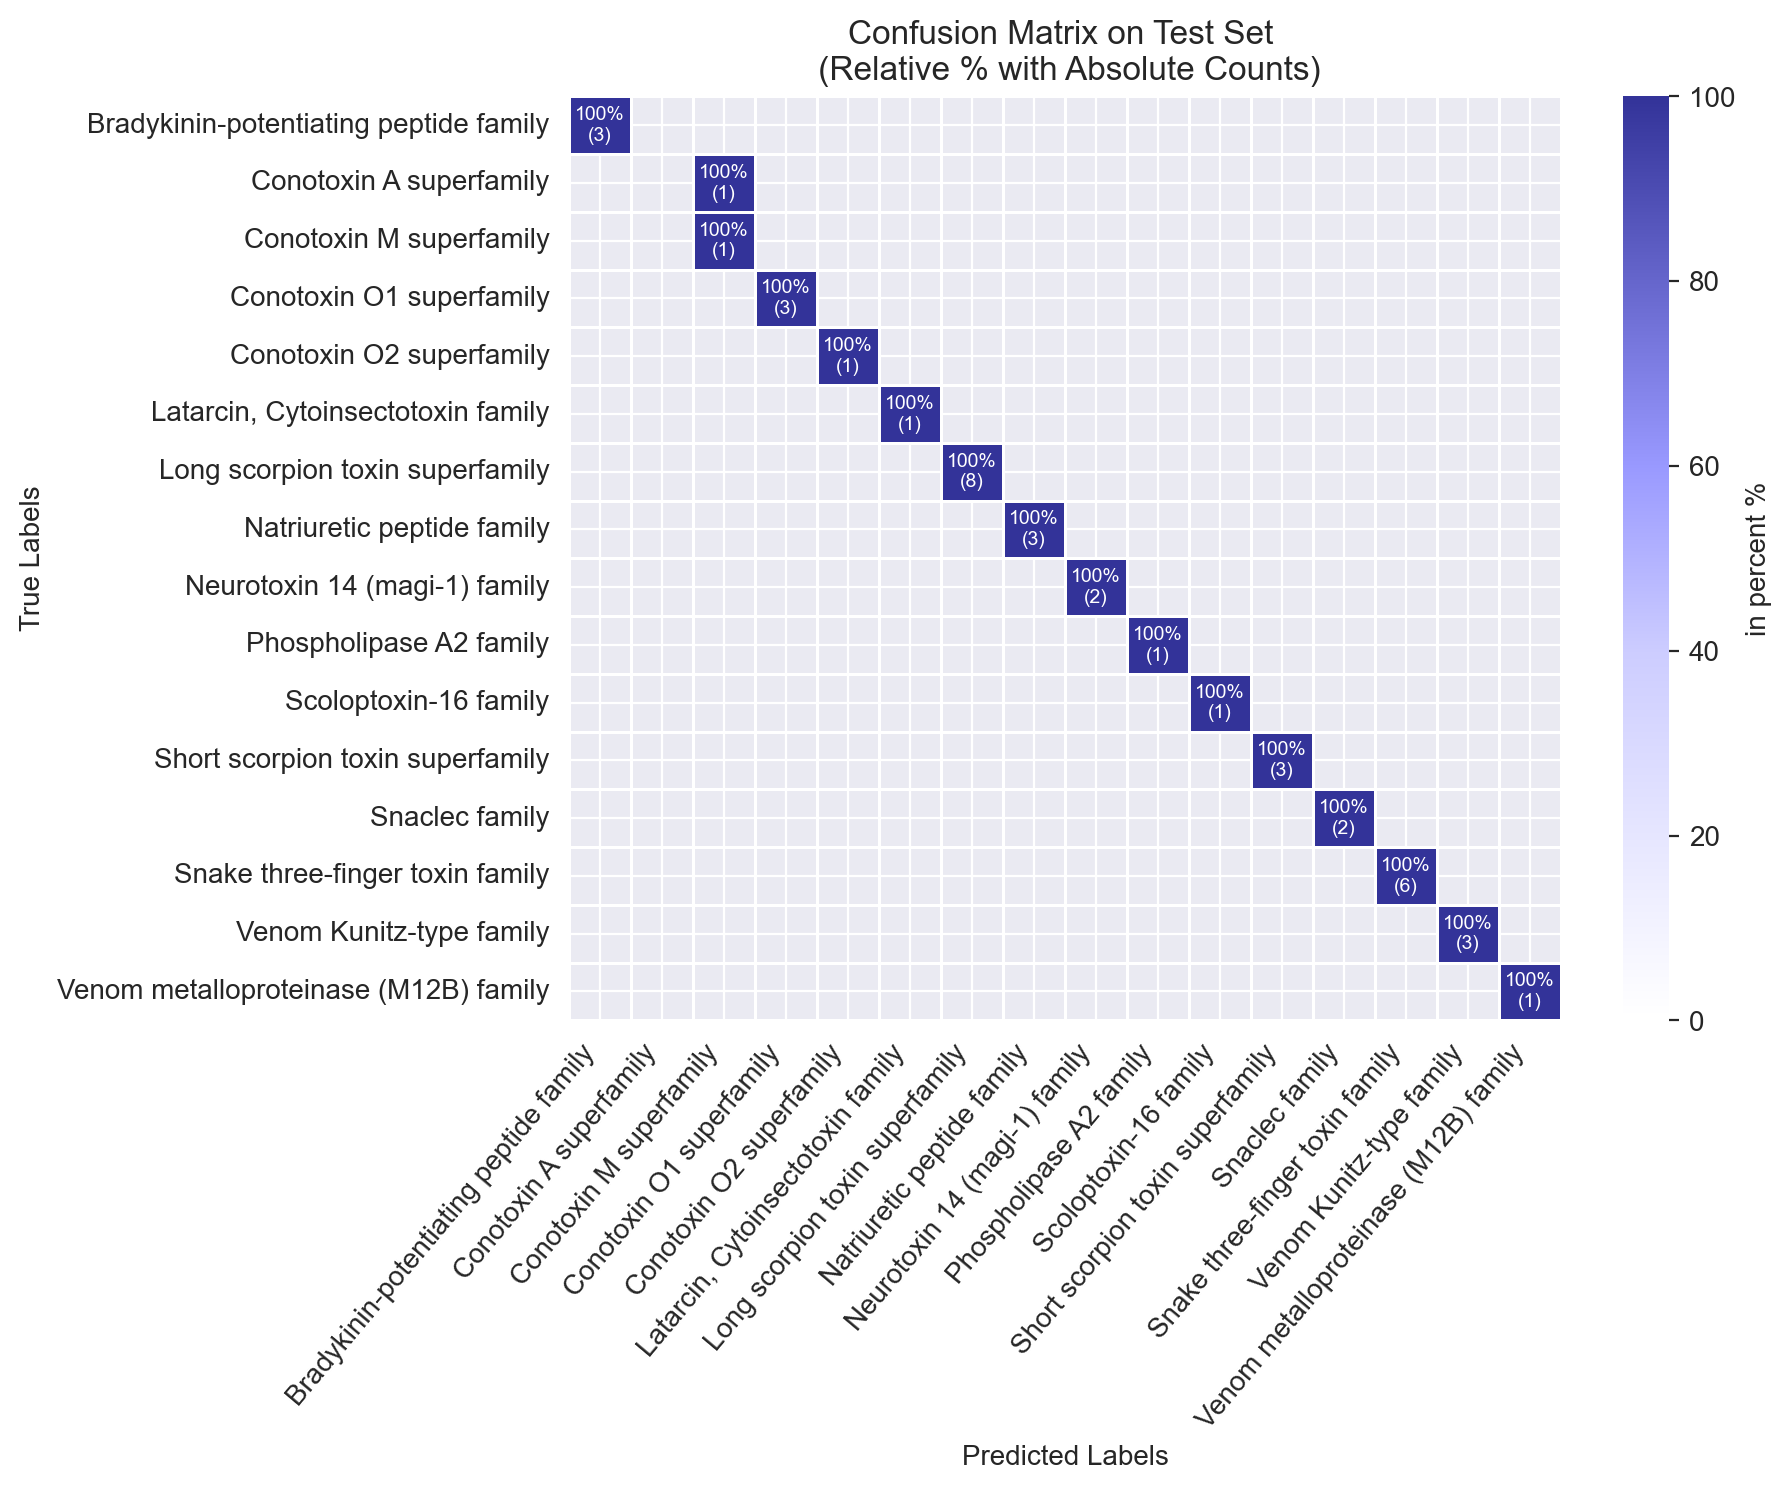

In [33]:
model.eval()  
with torch.no_grad():  
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)

    accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
    print(f"Test Accuracy: {accuracy:.4f}")

    mcc = matthews_corrcoef(y_test.numpy(), predicted.numpy())
    print(f"Test Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    
    # Confusion matrix
    predicted_labels = label_encoder.inverse_transform(predicted.numpy())
    true_labels = label_encoder.inverse_transform(y_test.numpy())
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_percentage = np.divide(cm.astype('float'), cm.sum(axis=1, keepdims=True), where=cm.sum(axis=1, keepdims=True) != 0) * 100
    cm_percentage = np.clip(cm_percentage, 0, 100)
    
    colors = [
        (1, 1, 1),        
        (0.9, 0.9, 1),    
        (0.8, 0.8, 1),     
        (0.6, 0.6, 1),     
        (0.4, 0.4, 0.8),   
        (0.2, 0.2, 0.6),  
    ]
    
    
    cmap = LinearSegmentedColormap.from_list("custom_lilac", colors)
    
    boundaries = np.linspace(0, 100, len(colors) + 1)
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)
    cm_percentage_no_zeros = np.where(cm == 0, np.nan, cm_percentage)

    fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
    
    sns.heatmap(
        cm_percentage_no_zeros,
        annot=False,
        cmap=cmap,
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        cbar_kws={'label': 'in percent %'},
        fmt=".0f",
        linewidths=1,  
        ax=ax,
        vmin=0, 
        vmax=100,
    )
    plt.xticks(rotation=50, ha='right')
    
    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                percentage_value = cm_percentage[i, j]
                if percentage_value % 1 == 0:
                    relative_text = f"{percentage_value:.0f}%"
                elif (round(percentage_value, 2) * 10) % 1 == 0:
                    relative_text = f"{percentage_value:.1f}%"
                else:
                    relative_text = f"{percentage_value:.2f}%"
                
                absolute_text = f"{cm[i, j]:d}"
                
                background_color = cmap(norm(percentage_value))
                brightness = (background_color[0] * 0.299 +
                              background_color[1] * 0.587 +
                              background_color[2] * 0.114)
                font_color = 'white' if brightness < 0.5 else 'black'
                
                ax.text(
                    j + 0.5, i + 0.5, 
                    f"{relative_text}\n({absolute_text})", 
                    ha='center', va='center', 
                    fontsize=7, color=font_color
                )
    
    # Titles and labels
    plt.title("Confusion Matrix on Test Set \n (Relative % with Absolute Counts)")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    
    # Save and show the plot
    plt.savefig("cm_test.png", bbox_inches='tight')
    plt.show()
